In [59]:
import matplotlib.pyplot as plt
import qutip as qt
import numpy as np
np.random.seed(123)

# Using predefined pulse functions

For user comfort and improved performance, `qutip-qoc` comes with a variety of Cython defined analytical pulses inside of its `pulse` module.
This notebook gives a brief overview and introduction about frequently found pulse functions.

Usually, the control task is implemented through a control operator ($H_c$), which can be defined by a sum of individual control operations (e.g. $\sigma_x, \sigma_y, \sigma_z$). Every single operator can be scaled by an analytical function that depends on some parameters $\vec{\alpha}$. In the example below, we can see a Hamiltonian that is made up of the three Pauli operators, each scaled by a sinusoidal pulse shape.

\begin{gather*}
H_c(\vec{\alpha}, t) =
\underbrace{c_0(\vec{\alpha}_0, t) \sigma_x}_{H_0(t, \vec{\alpha})}  
    +\underbrace{c_1(\vec{\alpha}_1, t) \sigma_y}_{H_1(t, \vec{\alpha})} 
    +\underbrace{c_2(\vec{\alpha}_2, t) \sigma_z}_{H_2(t, \vec{\alpha})} \\ \\
    c_k(\vec{\alpha}_k, t) = \alpha_{k,0} \cdot \sin(\alpha_{k,1} t + \alpha_{k,2})
\end{gather*}

Since it is often helpful to define a function basis in terms of a sum of sinusodials, the `qutip_qoc.pulse` module provides superposed sin functions like
\begin{align*}
    c_k(\vec{\alpha}_k, t) = \sum_i^{N_\mathrm{sup}} \alpha^i_{k,0} \cdot \sin(\alpha^i_{k,1} t + \alpha^i_{k,2}).
\end{align*}

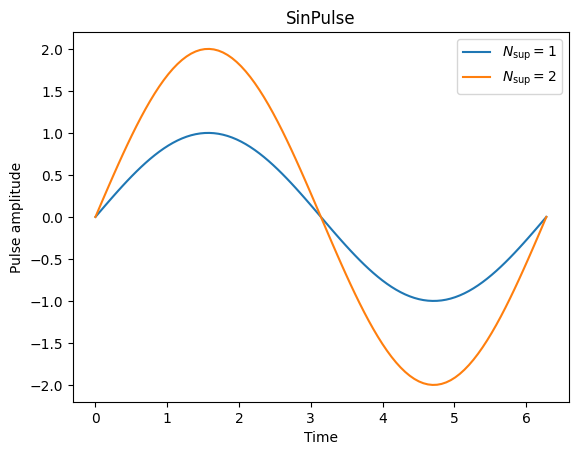

In [60]:
from qutip_qoc.pulse import SinPulse

# Create a SinPulse object
pulse_1 = SinPulse(n_sup=1)
pulse_2 = SinPulse(n_sup=2)

# Define the parameters for the sine pulse
parameters_1 = np.array([1., 1., 0.]) # [amplitude, frequency, phase]
parameters_2 = np.hstack([parameters_1, parameters_1])

# Generate the pulse values over a range of times
times = np.linspace(0, 2*np.pi, 100)
pulse_values_1 = np.array([pulse_1(time, parameters_1) for time in times])
pulse_values_2 = np.array([pulse_2(time, parameters_2) for time in times])

# Plot the pulse
def plot_pulse(times, pulse_values, title, legend):
    for pulse in pulse_values:
        plt.plot(times, pulse)
    plt.xlabel('Time')
    plt.ylabel('Pulse amplitude')
    plt.legend(legend)
    plt.title(title)
    plt.show()

plot_pulse(times, [pulse_values_1, pulse_values_2],
           'SinPulse', ['$N_\mathrm{sup}=1$', '$N_\mathrm{sup}=2$'])


We can define a function basis or single Gaussian pulse like:
\begin{align*}
    c_k(\vec{\alpha}_k, t) = \sum_i^{N_\mathrm{sup}} \alpha^i_{k,0} \cdot
    \exp\left( 
        -\frac{(t - \alpha^i_{k,1})^2}{(\alpha^i_{k,2})^2}
    \right).
\end{align*}

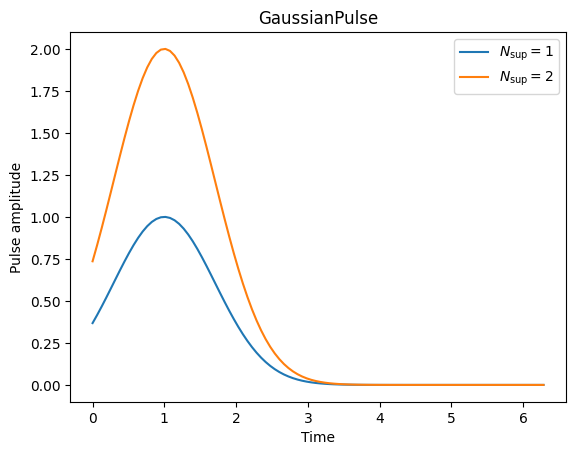

In [61]:
from qutip_qoc.pulse import GaussianPulse

# Create a GaussianPulse object
pulse_1 = GaussianPulse(n_sup=1)
pulse_2 = GaussianPulse(n_sup=2)

# Define the parameters for the gaussian pulse
parameters_1 = np.array([1., 1., 1.]) # [amplitude, width, center]
parameters_2 = np.hstack([parameters_1, parameters_1])

# Generate the pulse values over a range of times
times = np.linspace(0, 2*np.pi, 100)
pulse_values_1 = np.array([pulse_1(time, parameters_1) for time in times])
pulse_values_2 = np.array([pulse_2(time, parameters_2) for time in times])

# Plot the pulse
plot_pulse(times, [pulse_values_1, pulse_values_2],
           'GaussianPulse', ['$N_\mathrm{sup}=1$', '$N_\mathrm{sup}=2$'])

Since the GOAT algorithm does require to specify a functions derivatives the `pulse` module provides those right away.

In case of a cosine modulated cosine
\begin{align*}
    c_k(\vec{\alpha}_k, t) = \sum_i^{N_\mathrm{sup}} \alpha^i_{k,0} \cdot \cos(\alpha^i_{k,1} t + \alpha^i_{k,2}) \cdot \cos(\alpha^i_{k,3} t + \alpha^i_{k,4})
\end{align*}
the derivatives can be extracted as follows.

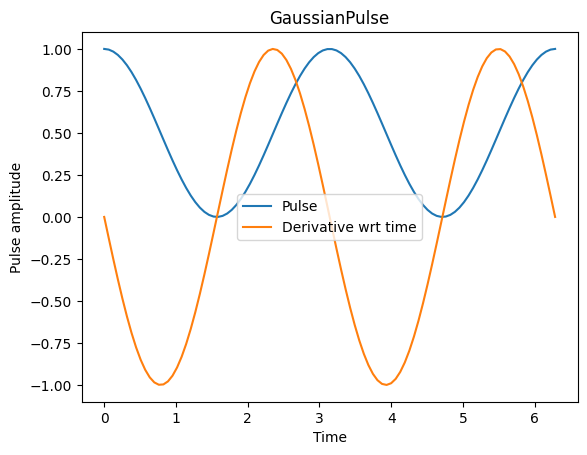

In [62]:
from qutip_qoc.pulse import CosCosPulse

# Create a CosCosPulse object
pls = CosCosPulse(n_sup=1)

# Define the parameters for the gaussian pulse
parameters = np.array([1., 1., 0., 1., 0.]) # [amplitude, frequency, phase, frequency, phase]

# Generate the pulse values over a range of times
times = np.linspace(0, 2*np.pi, 100)
pulse_values = np.array([pls.gen_pulse(time, parameters) for time in times])

derivative_values = []
for idx in range(pls.n_par + 1): # +1 for the time derivative
    derivative_values.append(
        np.array([pls.gen_grad(time, parameters, idx) for time in times])
    )

# Plot the pulse
plot_pulse(times, [pulse_values, derivative_values[-1]],
           'GaussianPulse', ['Pulse', 'Derivative wrt time'])

For a polynomial pulse (note: t is raised to power of $i$)
\begin{align*}
    c_k(\vec{\alpha}_k, t) = \sum_i^{N_\mathrm{sup}} \alpha^i_{k,0} \cdot (t)^i
\end{align*}

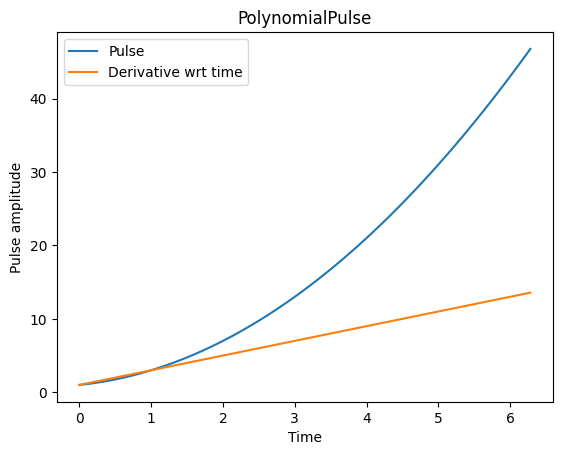

In [63]:
from qutip_qoc.pulse import PolynomialPulse

# Create a PolynomialPulse object
pls = PolynomialPulse(n_sup=1)

# Define the parameters for the polynomial pulse
parameters = np.array([1., 1., 1., 1., 1.]) # [p0, p1, p2, p3, ...]

# Generate the pulse values over a range of times
times = np.linspace(0, 2*np.pi, 100)
pulse_values = np.array([pls.gen_pulse(time, parameters) for time in times])

derivative_values = []
for idx in range(pls.n_par + 1): # +1 for the time derivative
    derivative_values.append(
        np.array([pls.gen_grad(time, parameters, idx) for time in times])
    )

# Plot the pulse
plot_pulse(times, [pulse_values, derivative_values[-1]],
           'PolynomialPulse', ['Pulse', 'Derivative wrt time'])


This setup makes it comfortable to define the control problem and solve it using `qutip_qoc.optimize_pulses`.

In [64]:
from qutip_qoc.pulse import FourierPulse

# Create a FourierPulse object
pls = FourierPulse(n_var=4)

# Define the parameters for the fourier pulse
parameters = np.array([1., 0., 0., 0.]) # [amplitude, frequency, phase, phase]

# Generate the pulse values over a range of times
times = np.linspace(0, 2*np.pi, 1000)

In [65]:
X, Y, Z = qt.sigmax(), qt.sigmay(), qt.sigmaz()

# Only necessary to make each function addressable by distinct signature
# (i.e. for qt.sesolve) however not strictly required for the pulse optimisation
pulse_x = lambda t, p: pls.gen_pulse(t, p)
pulse_y = lambda t, q: pls.gen_pulse(t, q)
pulse_z = lambda t, r: pls.gen_pulse(t, r)

H = [ 
    qt.qeye(2), # no drift
    [X, pulse_x, {'grad': pls.gen_grad}],
    [Y, pulse_y, {'grad': pls.gen_grad}],
    [Z, pulse_z, {'grad': pls.gen_grad}],
]

In [66]:
from qutip_qoc.optimize import optimize_pulses
from qutip_qoc.objective import Objective
from qutip_qoc.time_interval import TimeInterval

res_goat = optimize_pulses(
    objectives=[Objective(initial=qt.qeye(2), H=H, target=qt.sigmax())],
    pulse_options={ 
        "fourier_pulse": {
            "guess":  parameters,
            "bounds": [(-1,1) for _ in range(pls.n_par)]
        }
    },
    time_interval=TimeInterval(tslots=times),
    algorithm_kwargs={
        "alg": "GOAT",
        "fid_err_targ": 0.01,
    },
    optimizer_kwargs={},
    minimizer_kwargs={},
    integrator_kwargs={},
)

In [67]:
res_goat

Control Optimization Result
--------------------------
- Started at 2024-01-07 15:22:12
- Number of objectives: 1
- Final fidelity error: 0.0022537747898817573
- Final parameters: [array([ 1.        , -0.2553879 , -0.27473743,  0.04935452])]
- Number of iterations: 1
- Reason for termination: fid_err_targ reached
- Ended at 2024-01-07 15:22:12 (0.0095s)